In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import zipfile

zip_path_train = '/content/drive/MyDrive/Colab Notebooks/train.zip'
zip_path_test = '/content/drive/MyDrive/Colab Notebooks/test.zip'
zip_path_validation = '/content/drive/MyDrive/Colab Notebooks/valid.zip'
extract_path_train = '/content/drive/MyDrive/Colab Notebooks/'
extract_path_test = '/content/drive/MyDrive/Colab Notebooks/'
extract_path_validation = '/content/drive/MyDrive/Colab Notebooks/'

with zipfile.ZipFile(zip_path_train, 'r') as zip_ref:
    zip_ref.extractall(extract_path_train)

with zipfile.ZipFile(zip_path_test, 'r') as zip_ref:
    zip_ref.extractall(extract_path_test)

with zipfile.ZipFile(zip_path_validation, 'r') as zip_ref:
    zip_ref.extractall(extract_path_validation)


In [ ]:


import os
import torch
from torchvision import datasets
from torchvision.transforms import transforms

data_train = '/content/drive/MyDrive/Colab Notebooks/train'
data_test = '/content/drive/MyDrive/Colab Notebooks/test'
data_valid = '/content/drive/MyDrive/Colab Notebooks/valid'
target_size = (224, 224)  # VGG16 ve ResNet50'nin giriş boyutları


# Veri dönüştürme işlemleri
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),  # Giriş boyutuna göre yeniden boyutlandırma
        transforms.RandomHorizontalFlip(),  # Rastgele yatay çevirme
        transforms.RandomVerticalFlip(),  # Rastgele dikey çevirme
        transforms.RandomRotation(10),  # Rastgele döndürme
        transforms.ToTensor(),  # Tensor formatına dönüştürme
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalizasyon
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}



In [ ]:
# Veri yükleyici oluşturma
image_datasets = {
    'train': datasets.ImageFolder(os.path.join(data_train), data_transforms['train']),
    'val': datasets.ImageFolder(os.path.join(data_valid), data_transforms['val']),
    #'test': datasets.ImageFolder(os.path.join(data_test, 'test'), data_transforms['test'])
}

# Veri yükleyicileri oluşturma
batch_size = 32
dataloaders = {
    'train': torch.utils.data.DataLoader(image_datasets['train'], batch_size=batch_size, shuffle=True),
    'val': torch.utils.data.DataLoader(image_datasets['val'], batch_size=batch_size),
    #'test': torch.utils.data.DataLoader(image_datasets['test'], batch_size=batch_size)
}


In [ ]:
from PIL import Image

class TestDatasetFolder(torch.utils.data.Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        self.images = os.listdir(self.root)

    def __getitem__(self, index):
        image_path = os.path.join(self.root, self.images[index])
        image = Image.open(image_path)

        if self.transform is not None:
            image = self.transform(image)

        return image, 0  # 0, tüm görüntülerin aynı sınıfa ait olduğunu belirtmek için

    def __len__(self):
        return len(self.images)

test_data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
test_dataset = TestDatasetFolder(data_test, test_data_transforms)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)


In [ ]:
import torch
import torchvision.models as models

vgg16 = models.vgg16(pretrained=True)

resnet50 = models.resnet50(pretrained=True)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:05<00:00, 107MB/s] 
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future.

In [ ]:
for param in vgg16.parameters():
    param.requires_grad = False

for param in resnet50.parameters():
    param.requires_grad = False
    


In [ ]:
num_features = vgg16.classifier[6].in_features  # Get the input feature count of the last fully connected layer of the VGG16 model
vgg16.classifier[6] = torch.nn.Linear(num_features, 3)  # Change the output layer assuming it's a 3 class classification

num_features = vgg16.classifier[6].in_features  # Get the input feature count of the last fully connected layer of the VGG16 model
vgg16.classifier[6] = torch.nn.Linear(num_features, 3)  # Change the output layer assuming it's a 3 class classification


In [23]:

def calculate_accuracy(model, dataloader):
    model.eval()  # model to evaluation
    correct = 0
    total = 0
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)  

            outputs = model(images)  # model outputs
            _, predicted = torch.max(outputs.data, 1)  # pick max val

            total += labels.size(0)  
            correct += (predicted == labels).sum().item()  

    accuracy = 100 * correct / total
    return accuracy


Epoch: 1, Loss: 0.8335, Accuracy: 67.62%
Epoch: 2, Loss: 0.8166, Accuracy: 67.80%
Epoch: 3, Loss: 0.7964, Accuracy: 69.86%


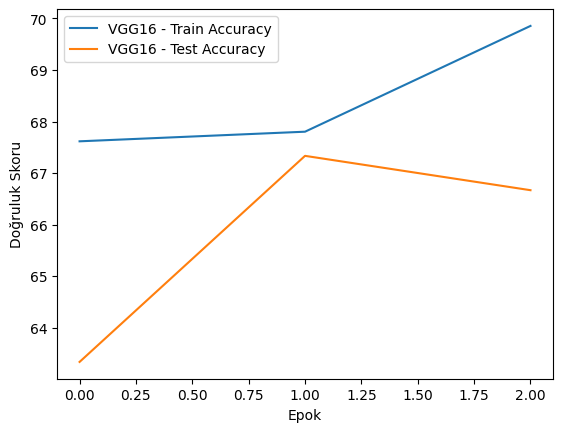

In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt




# criterion ve optimizer
criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(vgg16.parameters(), lr=0.001, momentum=momentum)
optimizer = optim.Adam(vgg16.parameters(), lr=0.001, betas=(0.9, 0.999))

#define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_accuracy_history_vgg = []
test_accuracy_history_vgg = []

num_epochs=3
# Train
for epoch in range(num_epochs):
    running_loss = 0.0
    correct = 0
    total = 0

    # For each dataset (training and validation)
    for phase in ['train', 'val']:
        if phase == 'train': #
            vgg16.train()  # the model to training mode
        else:
            vgg16.eval()   # Modeli değerlendirme moduna geçir

        # Veri kümesindeki her bir mini-batch için
        for inputs, labels in dataloaders[phase]:
            # Move Data GPU
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Zero gradients
            optimizer.zero_grad()

            # forward
            with torch.set_grad_enabled(phase == 'train'):
                outputs = vgg16(inputs)
                loss = criterion(outputs, labels)

                # back and optimizasyon
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            running_loss += loss.item() * inputs.size(0)

    train_accuracy = 100 * correct / total
    test_accuracy = calculate_accuracy(vgg16, dataloaders['val'])
    train_accuracy_history_vgg.append(train_accuracy)
    test_accuracy_history_vgg.append(test_accuracy)

    epoch_loss = running_loss / len(dataloaders['train'].dataset)
    epoch_accuracy = 100 * correct / total
    

  
    print('Epoch: {}, Loss: {:.4f}, Accuracy: {:.2f}%'.format(epoch+1, epoch_loss, epoch_accuracy))

plt.plot(train_accuracy_history_vgg, label='VGG16 - Train Accuracy')
plt.plot(test_accuracy_history_vgg, label='VGG16 - Test Accuracy')
plt.xlabel('Epok')
plt.ylabel('Doğruluk Skoru')
plt.legend()
plt.show()    


In [25]:
import csv

# Assuming you have your trained model stored in the 'model' variable
# Assuming you have your test dataloader in the 'test_dataloader' variable

# Set the model to evaluation mode
vgg16.eval()

#define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Make predictions on the test data
predictions = []
with torch.no_grad():
    for images,_ in test_dataloader:
        images = images.to(device)
        outputs = vgg16(images)
        _, predicted_labels = torch.max(outputs, 1)
        predictions.extend(predicted_labels.cpu().numpy())

# Create a list of dictionaries for each test sample with their predictions
results = [{'Prediction': prediction} for prediction in predictions]

# Define the path and filename for the CSV file
csv_file = 'test_predictions_vgg16.csv'

# Write the results to the CSV file
with open(csv_file, 'w', newline='') as file:
    fieldnames = ['Prediction']
    writer = csv.DictWriter(file, fieldnames=fieldnames)
    writer.writeheader()
    writer.writerows(results)

print(f"Test predictions saved to {csv_file}")


Test predictions saved to test_predictions_vgg16.csv
